# Linkit Beginner Challenge: Explainable Machine Learning using SHAP

SHAP (**SH**apley **A**dditive ex**P**lanations) can be used to interpret any model, i.e. it is **model-agnostic**
It is not necessary to fully understand the math behind SHAP, because this can get quite complex. For us, it is enough to understand how we can use them to explain machine learning models.

You can read more on SHAP in the [original paper](https://arxiv.org/abs/1705.07874) or on several tutorials like this [beginner intro](https://www.kaggle.com/code/dansbecker/shap-values) to shap values and the [advanced use cases tutorial](https://www.kaggle.com/code/dansbecker/advanced-uses-of-shap-values/tutorial)

## Your Task

Your task is to (1) train a classifier and (2) explain the classifier's predictions with shap values

Your submission we will be evaluated on the Accuracy of the classifer, as well as how well the explanation fit to the actual value.
For this, a few selected test points are held aside, for which you do not know the true values.


In [1]:
import os
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (
    LabelEncoder,
    OrdinalEncoder,
)
from sklearn.metrics import classification_report, PrecisionRecallDisplay
from sklearn.tree import DecisionTreeClassifier

shap.initjs()

In [2]:
DATA_PATH = os.path.join("data", "bank.csv")

## Data exploration

In [3]:
df = pd.read_csv(DATA_PATH)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
TARGET = "deposit"

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


## Attributes Description <br>

###  Bank client data:<br>
<a id="bank_client_data"></a>
1 - **age:** (numeric)<br>
2 - **job:** type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')<br>
3 - **marital:** marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
4 - **education:** (categorical: primary, secondary, tertiary and unknown)<br>
5 - **default:** has credit in default? (categorical: 'no','yes','unknown')<br>
6 - **housing:** has housing loan? (categorical: 'no','yes','unknown')<br>
7 - **loan:** has personal loan? (categorical: 'no','yes','unknown')<br>
8 - **balance:** Balance of the individual.
### Related with the last contact of the current campaign:
<a id="last_contact"></a>
8 - **contact:** contact communication type (categorical: 'cellular','telephone') <br>
9 - **month:** last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
10 - **day:** last contact day of the week (categorical: 'mon','tue','wed','thu','fri')<br>
11 - **duration:** last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.<br>
### other attributes:<br>
<a id="other_attributes"></a>
12 - **campaign:** number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
13 - **pdays:** number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)<br>
14 - **previous:** number of contacts performed before this campaign and for this client (numeric)<br>
15 - **poutcome:** outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')<br>

Output variable (desired target):<br>
21 - **deposit** - has the client subscribed a term deposit? (binary: 'yes','no')

<Axes: ylabel='deposit'>

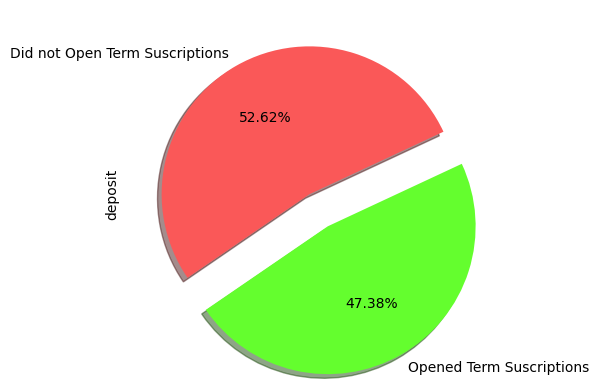

In [6]:
colors = ["#FA5858", "#64FE2E"]
labels = "Did not Open Term Suscriptions", "Opened Term Suscriptions"
df[TARGET].value_counts().plot.pie(
    explode=[0, 0.25],
    autopct="%1.2f%%",
    shadow=True,
    startangle=25,
    colors=colors,
    labels=labels,
)

In [7]:
# count how many unknowns are in the data frame
df.isin(["unknown"]).sum()

age             0
job            70
marital         0
education     497
default         0
balance         0
housing         0
loan            0
contact      2346
day             0
month           0
duration        0
campaign        0
pdays           0
previous        0
poutcome     8326
deposit         0
dtype: int64

We can see that `poutcome` has a lot of missing values represented by `unknown`.

### What is a Term Deposit? 
A **Term deposit** is a deposit that a bank or a financial institurion offers with a fixed rate (often better than just opening deposit account) in which your money will be returned back at a specific maturity time. For more information with regards to Term Deposits please click on this link from Investopedia:  https://www.investopedia.com/terms/t/termdeposit.asp

## Data Preprocessing

We have categorical features, so we need to apply some encoding and also label encoding on the target.

In [8]:
df_display = df.copy()
X_display = df.drop(columns=TARGET, axis=1)

df["deposit"] = LabelEncoder().fit_transform(df["deposit"])

In [9]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,1
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,1
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,1
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,1
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,1


In [10]:
df_categorical = df.select_dtypes(include="object")

for col in df_categorical.keys():
    df[col] = OrdinalEncoder(encoded_missing_value=-1, dtype=np.int64).fit_transform(
        df[col].values.reshape(-1, 1)
    )

df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,0,1,1,0,2343,1,0,2,5,8,1042,1,-1,0,3,1
1,56,0,1,1,0,45,0,0,2,5,8,1467,1,-1,0,3,1
2,41,9,1,1,0,1270,1,0,2,5,8,1389,1,-1,0,3,1
3,55,7,1,1,0,2476,1,0,2,5,8,579,1,-1,0,3,1
4,54,0,1,2,0,184,0,0,2,5,8,673,2,-1,0,3,1


## Model Selection

First, we need to split the data into a training and test set. We do this with the `train_test_split` function provided by `sklearn`.

Then, a simple `DecisionTreeClassifier` is fitted on the training set. 

In [11]:
X = df.drop(columns=TARGET, axis=1)
y = df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, shuffle=True, test_size=0.2
)

In [12]:
clf = DecisionTreeClassifier().fit(X_train, y_train)
clf.score(X_train, y_train)

1.0

In [13]:
clf.score(X_test, y_test)

0.7801164352888491

We see that this classifier overfits a lot, because the score on the test set is much lower. This is common with Decision trees with default parameters.

Feel free to change the classifier and its parameters or use hyper-parameter optimization frameworks like [Ray Tune](https://docs.ray.io/en/latest/tune/index.html) or [Optuna](https://optuna.org/) or just the exhaustive Grid Search of `sklearn` (`sklearn.model_selection.GridSearchCV`) to improve on the classifier performance.

In [14]:
print(classification_report(y_test, clf.predict(X_test), target_names=["No", "Yes"]))

              precision    recall  f1-score   support

          No       0.80      0.78      0.79      1175
         Yes       0.76      0.78      0.77      1058

    accuracy                           0.78      2233
   macro avg       0.78      0.78      0.78      2233
weighted avg       0.78      0.78      0.78      2233



### Classification Metrics

**Precision**: When we predict a positive, how sure are we?
In our case, the precision is 0.76 for the positive class (deposit = yes), meaning that the classifier is 76% sure that a positive prediction is correct.

**Recall**: How many of the positive cases did we catch?
Here, the recall is 0.77, meaning that the classifier caught 77% of the positive cases.

*Note: As precision increases, recall decreases. This is known as the precision-recall tradeoff.*

**F1 Score**: The harmonic mean of precision and recall. It is a good measure of accuracy, as it takes both false positives and false negatives into account.

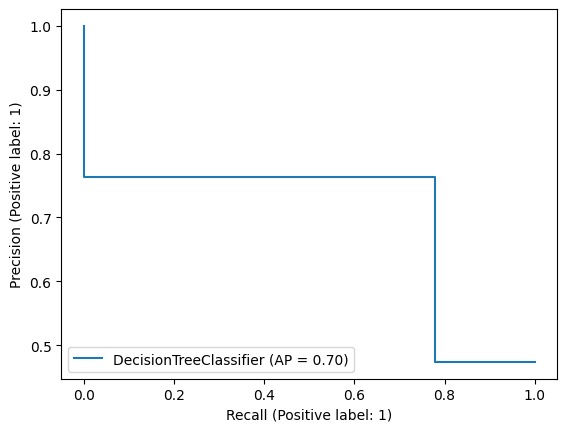

In [15]:
y_pred = clf.predict(X_test)
PrecisionRecallDisplay.from_predictions(y_test, y_pred, name="DecisionTreeClassifier")

## Explainable ML

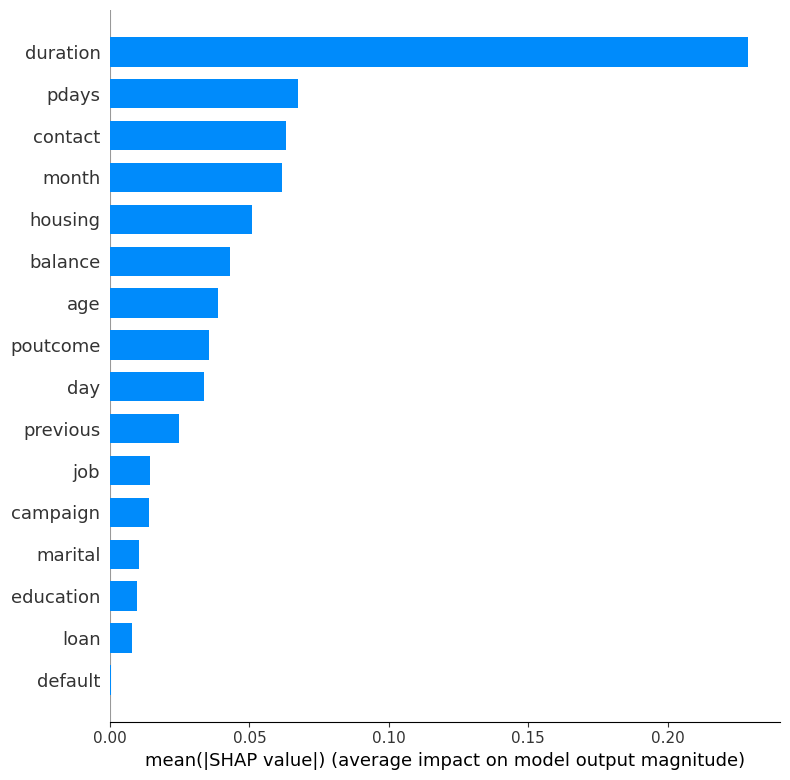

In [16]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)[1]
shap.summary_plot(shap_values, X, plot_type="bar")

The following plot is called a beeswarm plot and shows the shap values for *each sample* represented by a dot in the beeswarm plot.

Each dot has three characteristics:

- Vertical location shows what feature it is depicting
- Color shows whether that feature was high or low for that row of the dataset
- Horizontal location shows whether the effect of that value caused a higher or lower prediction.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


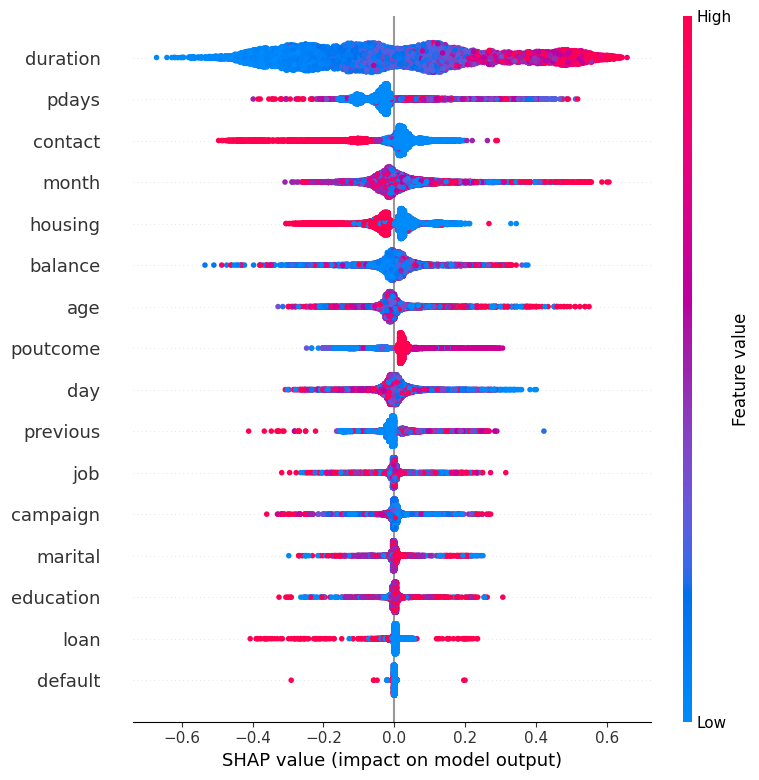

In [17]:
shap.summary_plot(shap_values, X)

In [18]:
idx = 0
shap.force_plot(
    explainer.expected_value[1],
    shap_values[idx, :],
    X_display.iloc[idx, :],
    link="logit",
)  # link=logit transforms the log-odds (raw output of the model) into probabilities

In [19]:
shap.force_plot(
    explainer.expected_value[1], shap_values[:1000, :], X_display.iloc[:1000, :]
)

### Dependence Contribution Plots

SHAP dependence plots show the effect of a single feature across the whole dataset. They plot a feature’s value vs. the SHAP value of that feature across many samples. SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions.

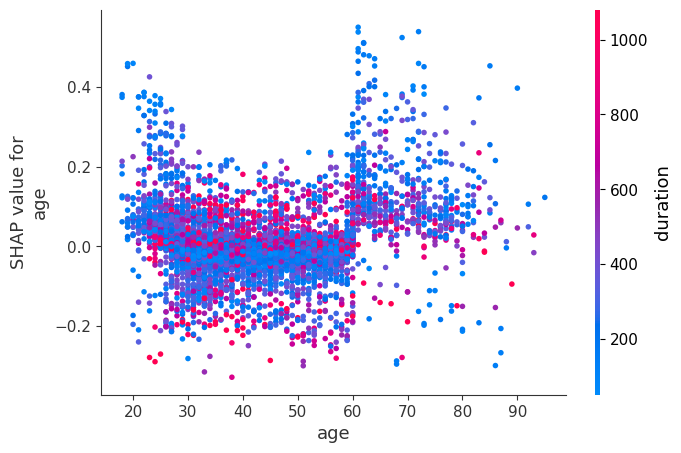

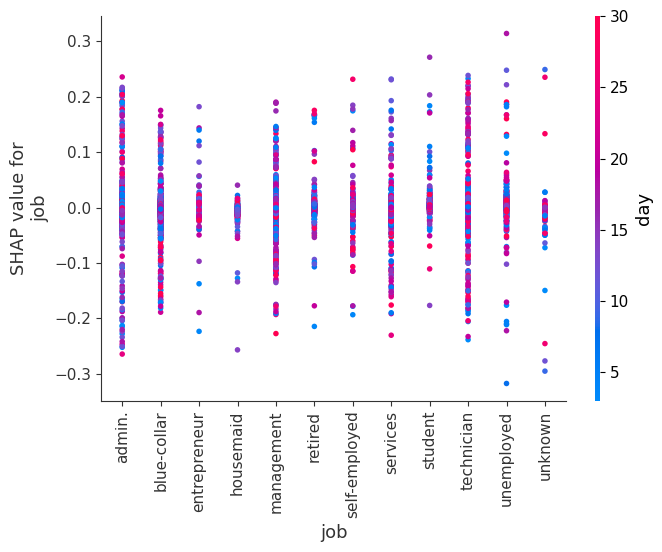

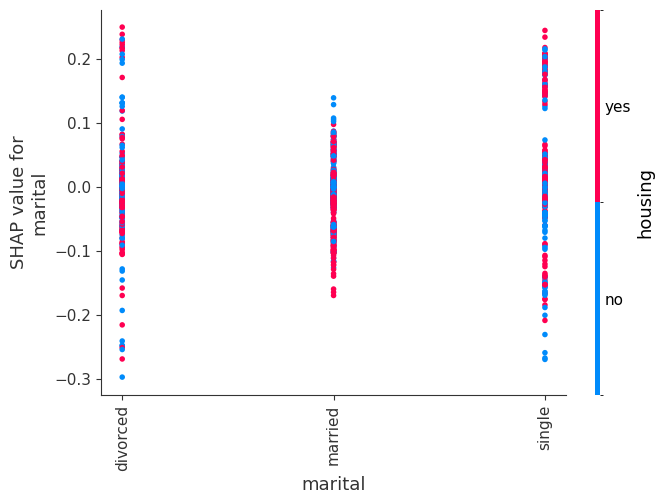

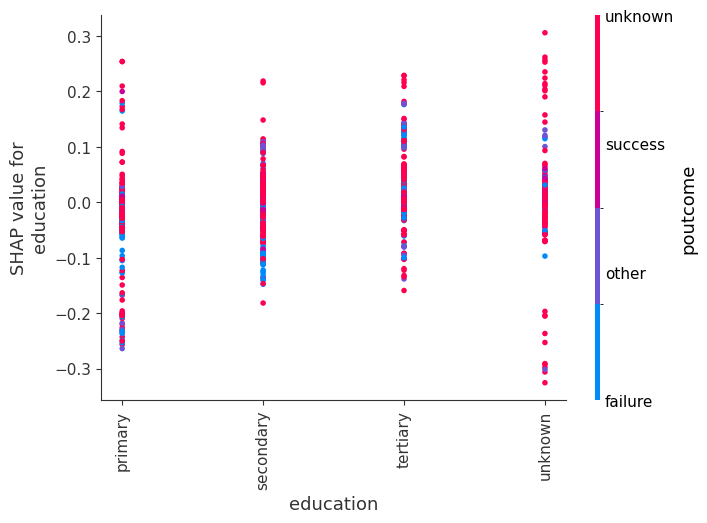

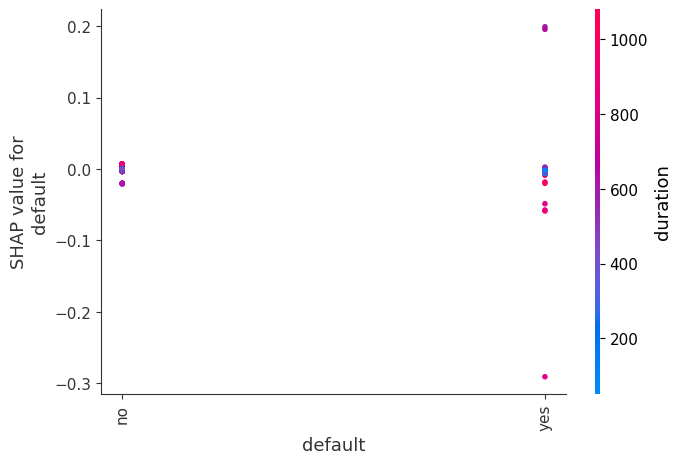

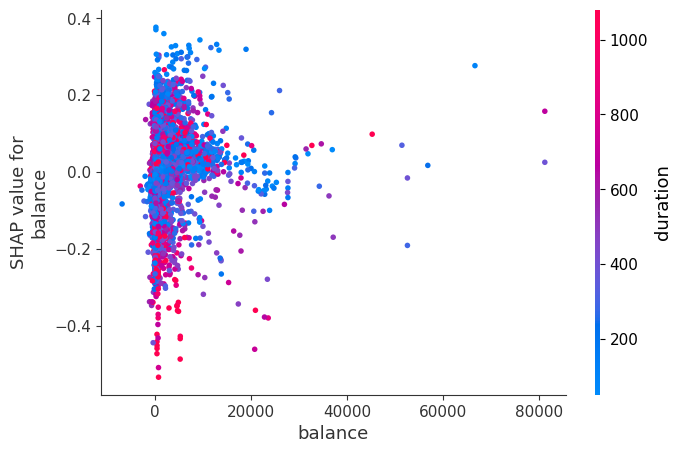

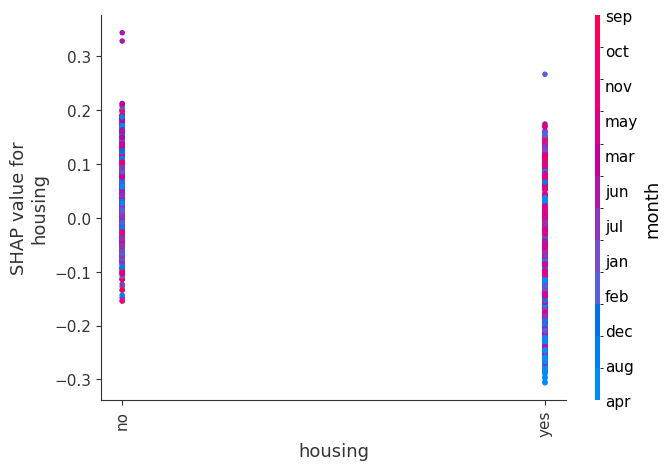

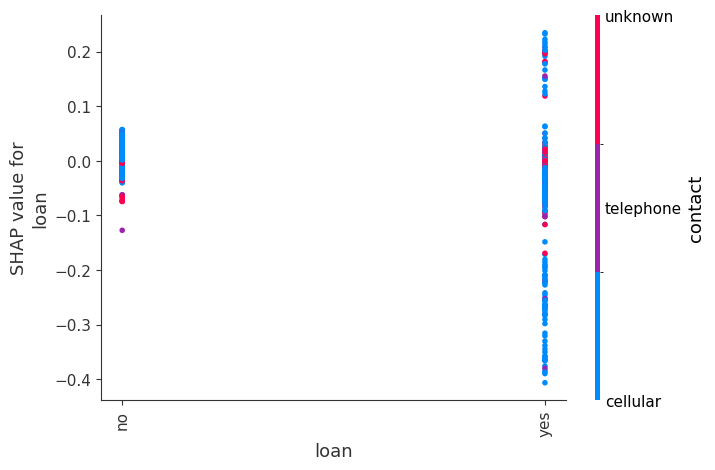

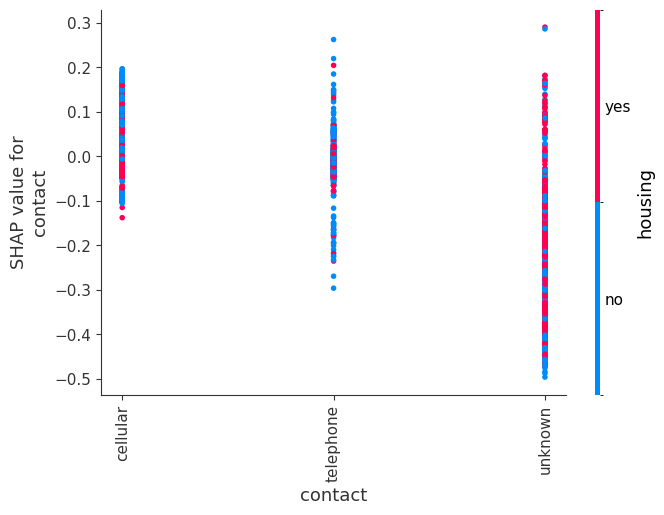

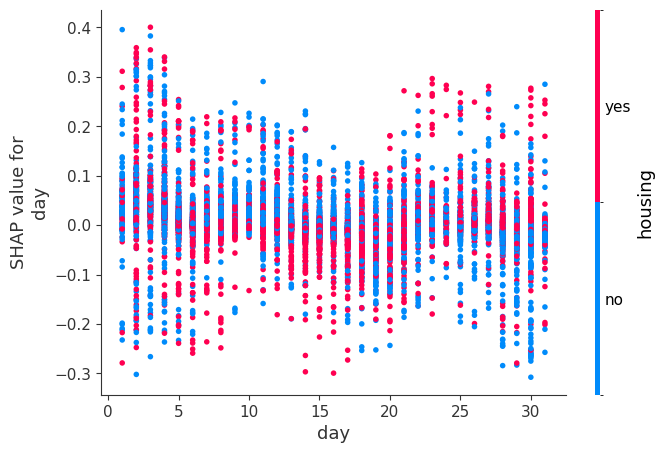

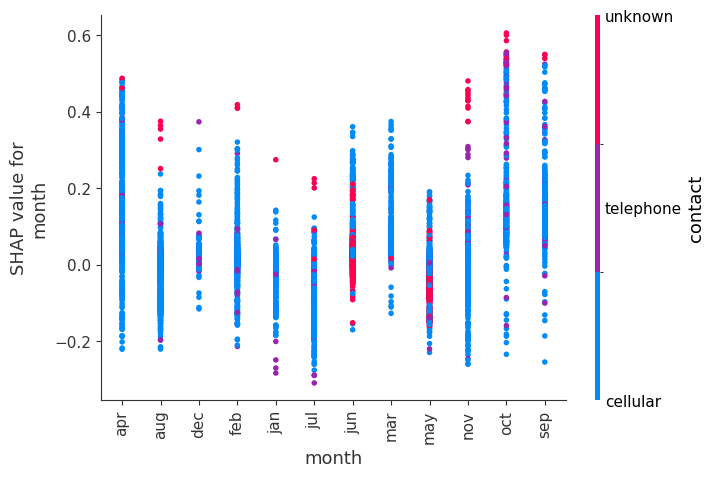

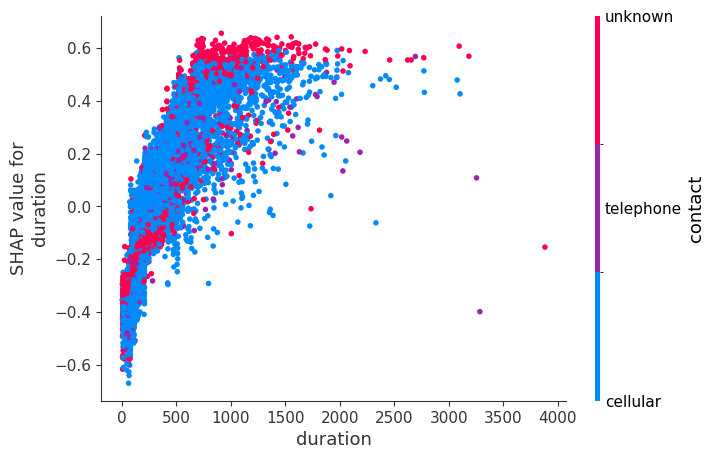

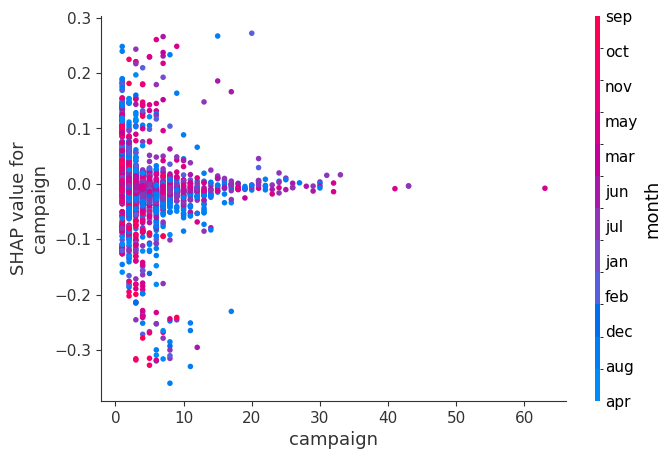

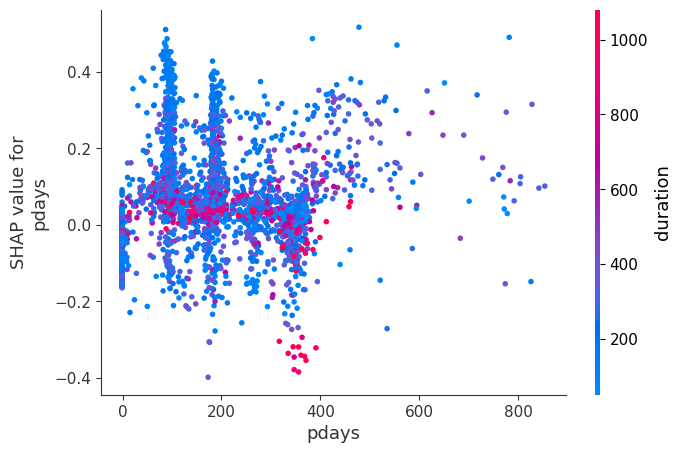

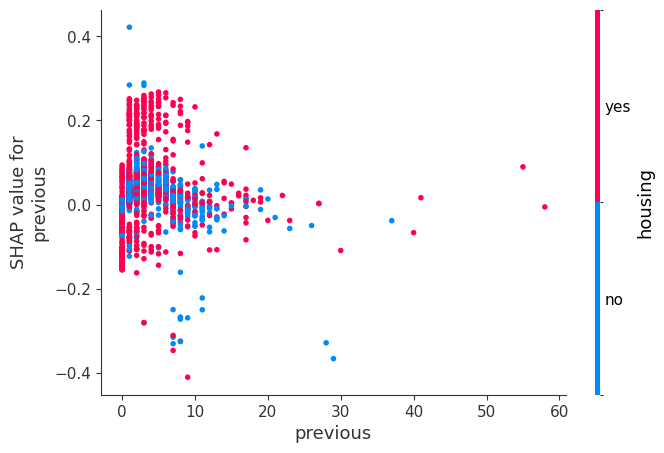

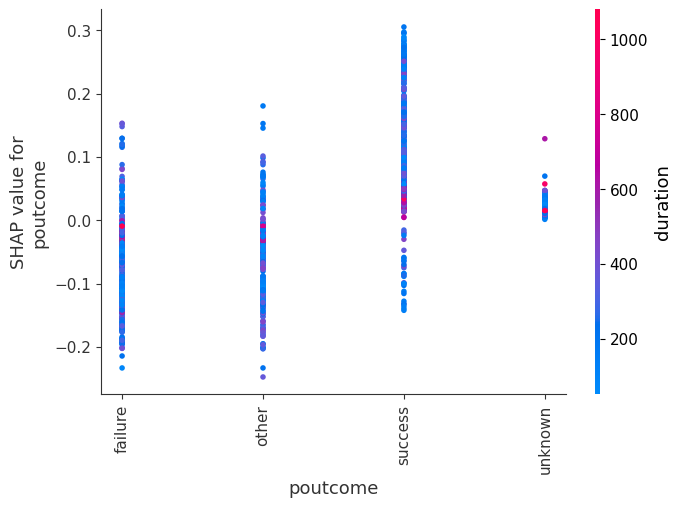

In [20]:
for name in X.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_display)